# Content
Random forest classifier models of Dividing v. Differentiating cells
1. Model of birth frame
2. Model of mother division frame
3. Model of mother division frame -12h

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from sklearn import preprocessing, model_selection
from sklearn import ensemble, metrics

def get_balanced_df_by_category(df,category):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member)
        else:
            output.append(member.sample(num_per_category.min()))
    output = pd.concat(output,ignore_index=True)

    return output


## 0. Load datasets

In [24]:
dirnames = {'R1':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R1/',
           'R2':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R2/'}
all_df = []
for name,dirname in dirnames.items():
    _df = pd.read_pickle(path.join(dirname,'Mastodon/single_timepoints_dynamics_aggregated_lookback_history.pkl'))
    _df = _df.drop_duplicates().sort_index().reset_index()
    _df['TrackID'] = name + '_' + _df['TrackID'].astype(str)
    _df = _df.set_index(['Frame','TrackID'])
    all_df.append(_df)

all_df = pd.concat(all_df)
all_tracks = {trackID:t for trackID,t in all_df.reset_index().groupby('TrackID')}


In [25]:
len(all_tracks)

2460

## 1. Categorize cell from its birth frame
1. Isolate birth frame data
2. Categorize will differentiate v. will divide

In [26]:
df = all_df[all_df['Fate known','Meta']]
df = df[ ~df['Border','Meta']]
df = df[ df['Cell type','Meta'] == 'Basal']

births = df[df['Birth frame','Meta']]
births[('Relative basal area','Measurement')] = \
    births['Basal area','Measurement'] / births['Mean adjac Basal area','Measurement']
births['bbox top - diff','Measurement'] = \
    births['Nuclear bbox top','Measurement'] - births['Z','Measurement']
births['bbox bottom - diff','Measurement'] = \
    births['Nuclear bbox bottom','Measurement']-births['Z','Measurement']
births_raw = births.copy()

features2drop = [f for f in births.columns.get_level_values(0) if 'Time to differentiation' in f]
# Censor height information
features2drop = features2drop + ['Z','Mean curvature - cell coords','Z-cyto','Height to BM',
                                 'Basal area','Apical area']
# Censor all exponential rates (but not mother's)
features2drop = features2drop + [f for f in births.columns.get_level_values(0)
                                 if ('exponential' in f and 'frame prior' not in f \
                                         and 'adjac' not in f)]
births = births.drop(columns=features2drop)


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_68837/1753210775.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  births[('Relative basal area','Measurement')] = \
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_68837/1753210775.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  births[('Relative basal area','Measurement')] = \
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_68837/1753210775.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

In [27]:
births

Name          Nuclear volume Nuclear solidity Nuclear bbox top  \
Metadata         Measurement      Measurement      Measurement   
Frame TrackID                                                    
1     R1_3          116.6250         0.848954             41.0   
      R1_4          101.6875         0.813500             42.0   
      R1_29         151.6250         0.854526             49.0   
      R1_30         143.4375         0.811815             41.0   
      R1_39         138.8750         0.915157             44.0   
...                      ...              ...              ...   
11    R2_1064       160.0625         0.822943             41.0   
      R2_1065       123.1250         0.861767             40.0   
      R2_1112       164.1250         0.833916             38.0   
      R2_1135       228.8750         0.887973             39.0   
12    R2_1091        99.5625         0.789004             45.0   

Name          Nuclear bbox bottom           Y           X Nuclear height  \
Metadata              Measurement Measurement Measurement    Measurement   
Frame TrackID                                                              
1     R1_3                   51.0  107.626340   36.175643          -10.0   
      R1_4                   52.0  106.917179   41.199754          -10.0   
      R1_29                  56.0   22.018343   78.469291           -7.0   
      R1_30                  52.0   18.079521   82.449455          -11.0   
      R1_39                  54.0   47.045792   87.840684          -10.0   
...                           ...         ...         ...            ...   
11    R2_1064                52.0   85.722276   25.094885          -11.0   
      R2_1065                49.0   81.018782   26.719289           -9.0   
      R2_1112                47.0  103.229817   39.728960           -9.0   
      R2_1135                52.0   15.694839   96.979929          -13.0   
12    R2_1091                56.0   81.698211   12.495763          -11.0   

Name          Cell volume      Y-cyto      X-cyto  ...  \
Metadata      Measurement Measurement Measurement  ...   
Frame TrackID                                      ...   
1     R1_3       278.5000  107.838252   36.528950  ...   
      R1_4       294.6250  107.045662   41.284525  ...   
      R1_29      291.5000   22.328259   78.436750  ...   
      R1_30      497.6875   17.353479   82.568693  ...   
      R1_39      345.6875   47.076930   87.743853  ...   
...                   ...         ...         ...  ...   
11    R2_1064    335.0625   85.614438   24.768234  ...   
      R2_1065    373.6875   81.241261   26.383802  ...   
      R2_1112    429.1875  102.970766   39.883974  ...   
      R2_1135    508.8750   15.600774   97.025239  ...   
12    R2_1091    400.3750   81.899313   12.427880  ...   

Name          Std adjac Cell volume (filter_name) exponential growth rate at 1 frame prior  \
Metadata                                                                       Measurement   
Frame TrackID                                                                                
1     R1_3                                                   NaN                             
      R1_4                                                   NaN                             
      R1_29                                                  NaN                             
      R1_30                                                  NaN                             
      R1_39                                                  NaN                             
...                                                          ...                             
11    R2_1064                                           0.003799                             
      R2_1065                                           0.003799                             
      R2_1112                                           0.002867                             
      R2_1135                                                NaN     

In [28]:

Niter = 100
metas = pd.DataFrame()
metas['name'] = births.xs('Meta',level=1,axis=1).columns
features = pd.DataFrame()

measurements = births.xs('Measurement',level=1,axis=1)
features['name'] = measurements.columns
features =features.set_index('name')
features['Num NA'] = measurements.isna().sum(axis=0)
# features = features.drop(features.loc[features.index.str.startswith('cyto_')].index)

feature_names = features.index
importances = pd.DataFrame(columns=feature_names)
avg_confusion = np.zeros((Niter,2,2))

for i in tqdm(range(Niter)):
    
    df_ = get_balanced_df_by_category(births, births['Will differentiate','Meta'].values)
    
    y = df_['Will differentiate','Meta']
    X = preprocessing.scale(df_.xs('Measurement',level=1,axis=1))
    
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y)
    
    forest = ensemble.RandomForestClassifier().fit(X_train,y_train)
    
    y_pred = forest.predict(X_test)
    avg_confusion[i,...] = metrics.confusion_matrix(y_test,y_pred)/len(y_test)

    importances.loc[i] = forest.feature_importances_


100%|█████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


### Plot birth frame category

name
nuc_shcoeffs_L5M0C                         0.003112
Collagen intensity smoothed growth rate    0.003216
cyto_shcoeffs_L4M0C                        0.003432
Basal alignment smoothed growth rate       0.003732
Basal area smoothed growth rate            0.003747
nuc_shcoeffs_L3M0C                         0.003959
Nuclear bbox top                           0.004069
bbox bottom - diff                         0.004199
Apical area smoothed growth rate           0.004630
Gaussian curvature - cell coords           0.004917
Nuclear bbox bottom                        0.005145
cyto_shcoeffs_L3M0C                        0.006262
Nuclear volume smoothed                    0.006313
cyto_shcoeffs_L5M0C                        0.006890
nuc_shcoeffs_L1M0C                         0.008647
cyto_shcoeffs_L1M0C                        0.011498
Relative basal area                        0.014256
Basal area smoothed                        0.016541
Cell volume smoothed growth rate           0.018377
Nuclear

Text(15.972222222222216, 0.5, 'Feature importance')

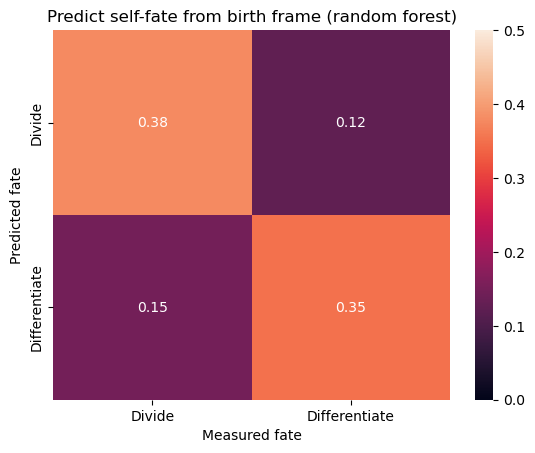

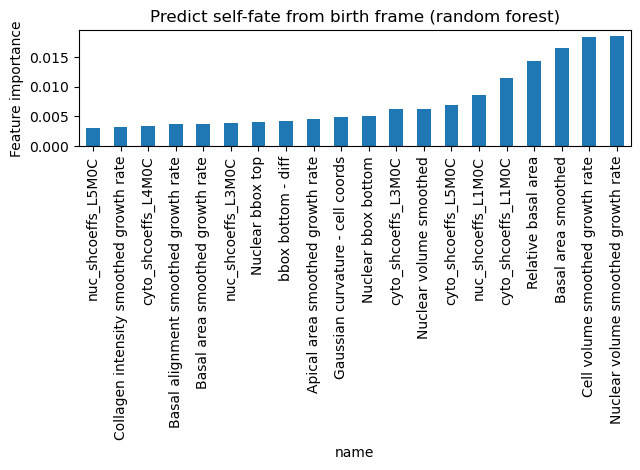

In [29]:

plt.title('Predict self-fate from birth frame (random forest)')
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
plt.gca().set_xticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.gca().set_yticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')

plt.figure()
plt.title('Predict self-fate from birth frame (random forest)')
print(importances.mean().sort_values().tail(20))
importances.mean().sort_values().tail(20).plot.bar(); plt.tight_layout();
plt.ylabel('Feature importance')


/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 5.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 10.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 9.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


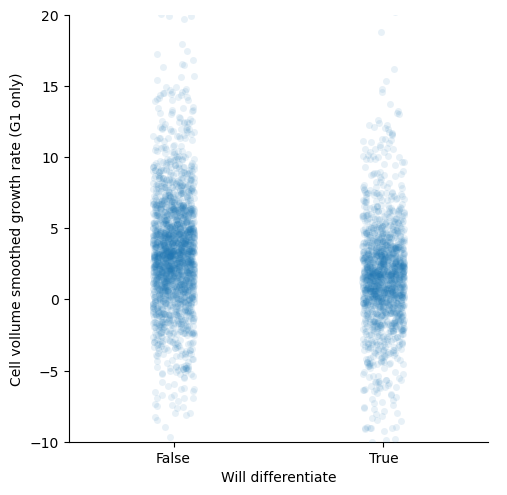

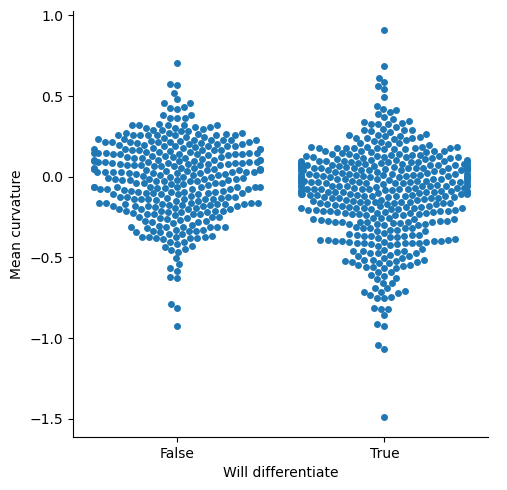

In [30]:
# Visualize features

sb.catplot(all_df[all_df['Fate known','Meta'] & (all_df['Cell cycle phase','Meta'] == 'G1')].droplevel(level=1,axis=1),
           x='Will differentiate',y='Cell volume smoothed growth rate',kind='strip',alpha=0.1)
plt.ylim([-10,20]); plt.ylabel('Cell vollume smoothed growth rate (G1 only)')

# sb.catplot(births_raw.droplevel(level=1,axis=1),x='Will differentiate',y='Cell volume exponential growth rate')

sb.catplot(births_raw.droplevel(level=1,axis=1),x='Will differentiate',y='Mean curvature',kind='swarm')

# sb.catplot(births_raw.droplevel(level=1,axis=1),x='Will differentiate',y='Basal area')

## 2. Predict daughter fate from mother division frame
Daughter fate: 0 delaminating, 1 delaminating or 2 delaminating

In [39]:
BALANCE = True
Niter = 100

# feature2predict = 'At least one daughter differentiated'
# feature2predict = 'Both daughters differentiated'
feature2predict = 'Num daughter differentiated'

df = all_df[all_df['Fate known','Meta']]
df = df[ df['Cell type','Meta'] == 'Basal']

divisions = df[df[('Divide next frame','Meta')]]
divisions = divisions[~divisions['Border','Meta']]
divisions = divisions.reset_index().set_index('TrackID')
divisions[('Relative basal area','Measurement')] = \
    divisions['Basal area','Measurement'] / divisions['Mean adjac Basal area','Measurement']



In [46]:
df_.droplevel(level=1,axis=1).groupby(feature2predict).count()

Name,Frame,Nuclear volume,Nuclear solidity,Nuclear bbox top,Nuclear bbox bottom,Z,Y,X,Nuclear height,Cell volume,...,Median adjac Nuclear volume (filter_name) exponential growth rate at 1 frame prior,Std adjac Nuclear volume (filter_name) exponential growth rate at 1 frame prior,Std adjac Cell volume (filter_name) exponential growth rate at 1 frame prior,Mean adjac Reviewed by at 1 frame prior,Cell volume (filter_name) exponential growth rate at 1 frame prior,Min adjac Nuclear volume (filter_name) exponential growth rate at 1 frame prior,Median adjac Reviewed by at 1 frame prior,Max adjac Reviewed by at 1 frame prior,Mean adjac Cell volume (filter_name) exponential growth rate at 1 frame prior,Relative basal area
Num daughter differentiated,,,,,,,,,,,,,,,,,,,,,
0.0,72,72,72,72,72,72,72,72,72,72,...,30,30,30,31,9,30,31,31,30,48
1.0,72,72,72,72,72,72,72,72,72,71,...,21,21,20,23,8,21,23,23,20,60
2.0,72,72,72,72,72,72,72,72,72,72,...,33,33,33,34,10,33,34,34,33,52


In [42]:

features2drop = [f for f in df.columns.get_level_values(0) if 'Time' in f]
features2drop += [f for f in df.columns.get_level_values(0) if 'Age' in f]

features2drop = [(f,'Measurement') for f in features2drop]
features2drop = features2drop + [('Keep until first differentiation','Meta')]
divisions = divisions.drop(columns=features2drop).dropna(
    subset=[(feature2predict,'Meta')])

feature_names = divisions.xs('Measurement',axis=1,level=1).columns
importances = pd.DataFrame(columns=feature_names)
avg_confusion = np.zeros((Niter,3,3))

for i in tqdm(range(Niter)):
    
    if BALANCE:
        df_ = get_balanced_df_by_category(divisions,
                                          divisions[(feature2predict,'Meta')].values)
    else:
        df_ = divisions
        
    _tmp = df_.xs('Measurement',level=1,axis=1).copy()
    _tmp[feature2predict] = df_[(feature2predict,'Meta')].copy()
    
    y = _tmp[feature2predict].values
    X = preprocessing.scale(_tmp.drop(columns=feature2predict))
    
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.1)
    
    forest = ensemble.RandomForestClassifier().fit(X_train,y_train)
    
    y_pred = forest.predict(X_test)
    avg_confusion[i,...] = metrics.confusion_matrix(y_test,y_pred)/len(y_test)
    
    importances.loc[i] = forest.feature_importances_


100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.09it/s]


Name
Mean adjac cyto_shcoeffs_L1M0C                      0.001891
nuc_shcoeffs_L5M0C                                  0.001959
Median adjac Cell volume exponential growth rate    0.002029
cyto_shcoeffs_L0M0C                                 0.002063
nuc_shcoeffs_L3M2S                                  0.002072
Height to BM at 1 frame prior                       0.002103
Mean adjac Cell volume standard                     0.002116
Mean adjac Cell volume smoothed                     0.002129
Median adjac Cell volume smoothed                   0.002264
nuc_shcoeffs_L3M0C                                  0.002313
cyto_shcoeffs_L1M0C                                 0.002562
Axial component                                     0.002903
Median adjac Cell volume standard                   0.003007
nuc_shcoeffs_L1M0C                                  0.003302
Height to BM                                        0.003650
Mean curvature - cell coords                        0.004102
Basal area smoothed

Text(24.847222222222214, 0.5, 'Feature importance')

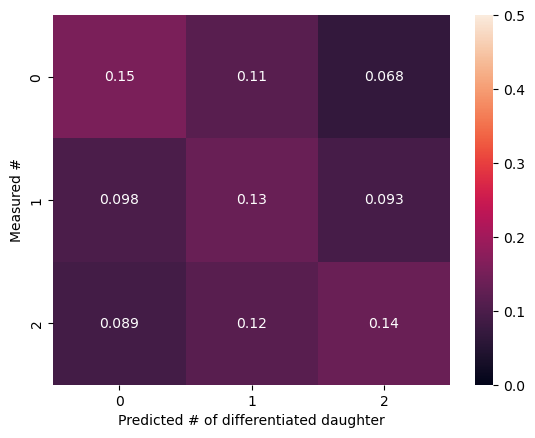

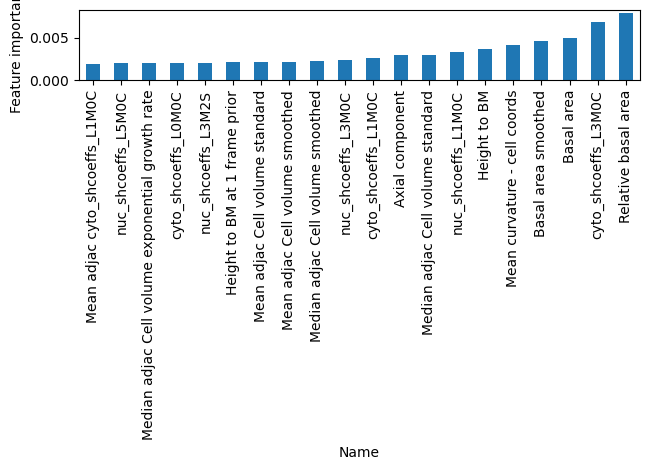

In [47]:
# Plot mother division model results
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
plt.xlabel('Predicted # of differentiated daughter')
plt.ylabel('Measured #')
print(importances.mean().sort_values().tail(20))

plt.figure()
importances.mean().sort_values().tail(20).plot.bar(); plt.tight_layout();
plt.ylabel('Feature importance')


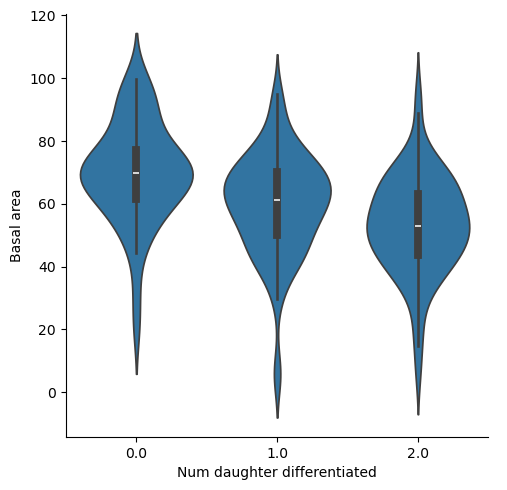

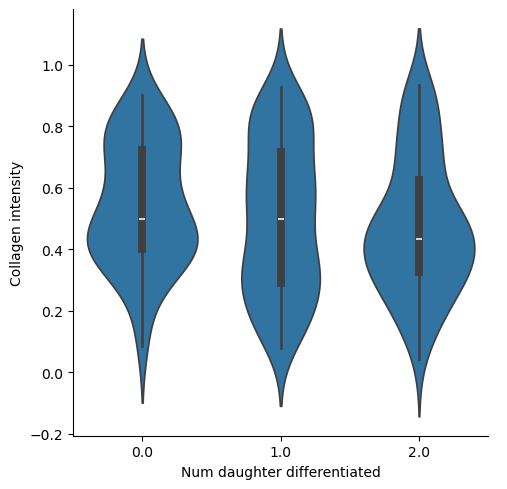

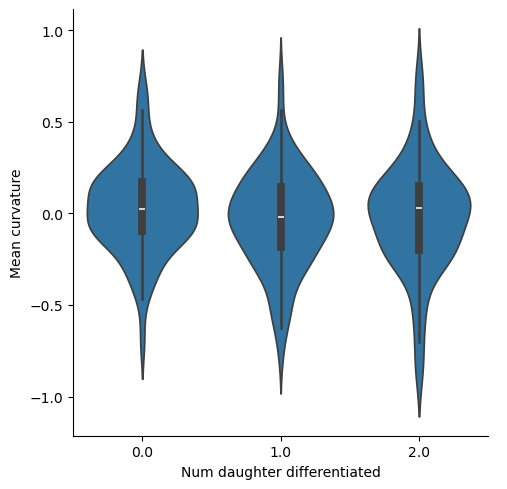

In [49]:
# Visualize features

# sb.catplot(divisions.droplevel(level=1,axis=1),x='Will differentiate',y='Cell volume exponential growth rate')
sb.catplot(divisions.droplevel(level=1,axis=1),x='Num daughter differentiated',y='Basal area',kind='violin')
sb.catplot(divisions.droplevel(level=1,axis=1),x='Num daughter differentiated',y='Collagen intensity',kind='violin')
sb.catplot(divisions.droplevel(level=1,axis=1),x='Num daughter differentiated',y='Mean curvature',kind='violin')

## 3. 12h prior to mother division frame
- NB: Not enough cells

In [50]:
# Grab frame prior to mother division -- takes a while
from measurements import get_prev_or_next_frame

BALANCE = True
Niter = 100

# feature2predict = 'At least one daughter differentiated'
# feature2predict = 'Both daughters differentiated'
feature2predict = 'Num daughter differentiated'

df = all_df[all_df['Fate known','Meta']]
df = df[ df['Cell type','Meta'] == 'Basal']

divisions = df[df[('Divide next frame','Meta')]]
divisions = divisions[~divisions['Border','Meta']]
divisions = divisions.reset_index().set_index('TrackID')

prev_div_frame = [get_prev_or_next_frame(all_df,f,direction='prev') for _,f in tqdm(divisions.iterrows())]
prev_div_frame = pd.concat(prev_div_frame,axis=1).T
prev_div_frame = df[df[('Divide next frame','Meta')]]
prev_div_frame = prev_div_frame[~prev_div_frame['Border','Meta']]
prev_div_frame = prev_div_frame.reset_index().set_index('TrackID')


ModuleNotFoundError: No module named 'measurements'

In [8]:
# Drop unneeded features
features2drop = [f for f in df.columns.get_level_values(0) if 'Time' in f]
features2drop += [f for f in df.columns.get_level_values(0) if 'Age' in f]
features2drop = [(f,'Measurement') for f in features2drop]
features2drop = features2drop + [('Keep until first differentiation','Meta')]
divisions = prev_div_frame.drop(columns=features2drop).dropna(subset=[(feature2predict,'Meta')])

# Run model
feature_names = prev_div_frame.xs('Measurement',axis=1,level=1).columns
importances = pd.DataFrame(columns=feature_names)
avg_confusion = np.zeros((Niter,3,3))

for i in tqdm(range(Niter)):
    
    if BALANCE:
        df_ = get_balanced_df_by_category(prev_div_frame, prev_div_frame[(feature2predict,'Meta')].values)
    else:
        df_ = divisions
    
    _tmp = df_.xs('Measurement',level=1,axis=1).copy()
    _tmp[feature2predict] = df_[(feature2predict,'Meta')].copy()
    
    y = _tmp[feature2predict].values
    X = preprocessing.scale(_tmp.drop(columns=feature2predict))
    
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.1)
    
    forest = ensemble.RandomForestClassifier().fit(X_train,y_train)
    
    y_pred = forest.predict(X_test)
    avg_confusion[i,...] = metrics.confusion_matrix(y_test,y_pred)/len(y_test)
    
    importances.loc[i] = forest.feature_importances_


/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:243: RuntimeWarning: Mean of empty slice
  mean_ = np.nanmean(X, axis)
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:251: RuntimeWarning: Mean of empty slice
  mean_1 = np.nanmean(Xr, axis=0)
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:270: RuntimeWarning: Mean of empty slice
  mean_2 = np.nanmean(Xr, axis=0)
/opt/miniconda3/envs/pyt

In [1]:
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
plt.xlabel('Predicted # of differentiated daughter')
plt.ylabel('Measured #')
print(importances.mean().sort_values().tail(20))

NameError: name 'sb' is not defined